In [1]:
from matplotlib import pyplot as plt
from math import sin, pi
import numpy as np
import torch
import torchaudio
import torchaudio.transforms as transforms
from IPython.display import Audio

import pyworld as pw

## Data

In [2]:
music_file = "data/portishead_dummy_short.mp3"
waveform, fs = torchaudio.load(music_file)
print(f"Sample rate: {fs}")
Audio(music_file)

Sample rate: 44100


## Speech Template

In [3]:
waveform.shape

torch.Size([2, 673540])

In [4]:
waveform0 = np.ascontiguousarray(waveform[0, :].numpy().astype(np.double))
_f0, t = pw.dio(waveform0, fs, frame_period=10) # raw pitch extractor;
# _f0, t = pw.dio(waveform0, fs) # raw pitch extractor;
f0 = pw.stonemask(waveform0, _f0, t, fs)  # pitch refinement
sp = pw.cheaptrick(waveform0, f0, t, fs)  # extract smoothed spectrogram
ap = pw.d4c(waveform0, f0, t, fs)         # extract aperiodicity

In [5]:
help(pw.dio)

Help on cython_function_or_method in module pyworld.pyworld:

dio(x, fs, f0_floor=71.0, f0_ceil=800.0, channels_in_octave=2.0, frame_period=5.0, speed=1, allowed_range=0.1)
    DIO F0 extraction algorithm.
    
    Parameters
    ----------
    x : ndarray
        Input waveform signal.
    fs : int
        Sample rate of input signal in Hz.
    f0_floor : float
        Lower F0 limit in Hz.
        Default: 71.0
    f0_ceil : float
        Upper F0 limit in Hz.
        Default: 800.0
    channels_in_octave : float
        Resolution of multiband processing; normally shouldn't be changed.
        Default: 2.0
    frame_period : float
        Period between consecutive frames in milliseconds.
        Default: 5.0
    speed : int
        The F0 estimator may downsample the input signal using this integer factor
        (range [1;12]). The algorithm will then operate on a signal at fs/speed Hz
        to reduce computational complexity, but high values may negatively impact
        accura

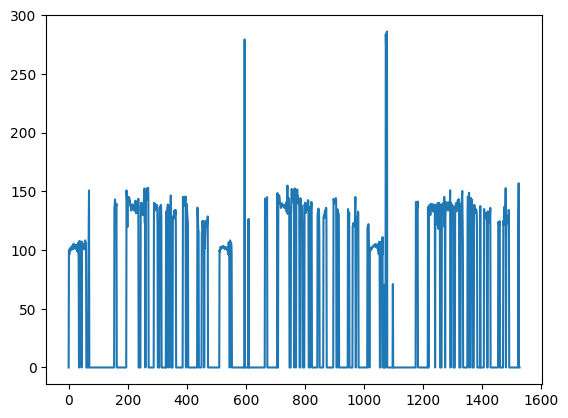

In [6]:
plt.plot(f0)

In [7]:
print(f'Spectrogram shape: {sp.shape[0]}, {sp.shape[1]}')

Spectrogram shape: 1528, 1025


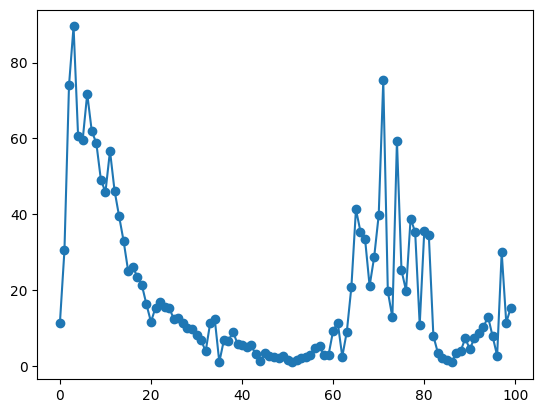

In [8]:
plt.plot(sp[:100].sum(axis=1), '-o')

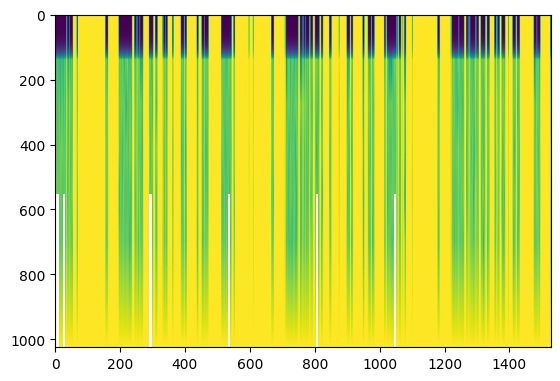

In [9]:
# plt.imshow(sp.T)
plt.imshow(ap.T)

In [10]:
# y = pw.synthesize(f0, sp, ap, fs) # synthesize an utterance using the parameters
# Audio(y, rate=fs)

In [11]:
# # The synthesized audio has very low volume in display.Audio. Thus, save to a file and examine it using other players. 
# import soundfile as sf
# sf.write("data/synthesized.wav", y, fs)


In [12]:
# Speech template includes two key pieces of information:
# 1. the duration between two pulese is the reciprocal of the pitch.
# 2. the intensity of the pulse is calculated from the mel-spectrogram. But how?    

In [13]:
# Smartguess the hop length in msec => 5 msec
waveform0.shape[0]/f0.shape[0]/44.1

9.995429236266933

In [14]:
# spectrogram intensity = sum along mel-freq axis
sp_intensity = sp.sum(axis=1)
sp_intensity /= sp_intensity.max()

In [15]:
# Vectorized (f0, sp, ap): abs(f0_44100Hz) x sp_intensity_44100Hz
# Inperpolation ap to the same length as f0
x = np.linspace(0, 1, len(f0))
xvals = np.linspace(0, 1, len(waveform0))
f0_long = np.interp(xvals, x, f0)

In [16]:
x = list(range(len(waveform0)))
f0_modulated = [sin(2*np.pi*f0_long[i]*i/fs) for i in x]

In [17]:
x = np.linspace(0, 1, len(sp_intensity))
xvals = np.linspace(0, 1, len(waveform0))
sp_intensity_long = np.interp(xvals, x, sp_intensity)

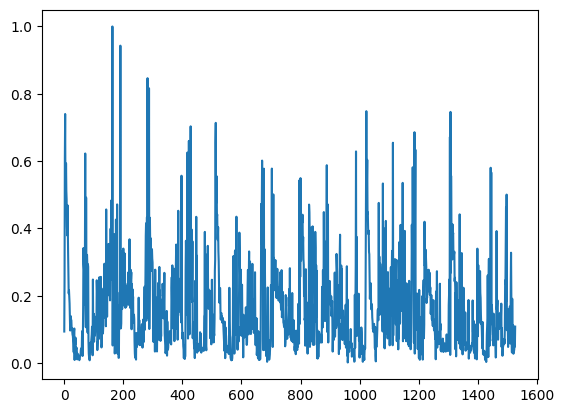

In [18]:
plt.plot(sp_intensity)

In [19]:
speech_template = np.abs(f0_modulated)*sp_intensity_long

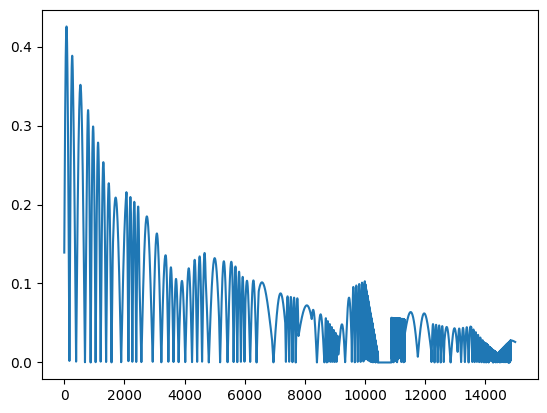

In [20]:
plt.plot(speech_template[5000:20000])

## Forward function of RefineGAN generator

In [133]:
import torch.nn as nn
import torch.nn.functional as F


class ResBlock(nn.Module):  # ResBlock: resnet block
    def __init__(self, resnet_length):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv1d(resnet_length, resnet_length, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(resnet_length, resnet_length, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        return x

class RefineGAN(nn.Module):
    def __init__(self, hopsize_msec=4, fs=fs):
        super(RefineGAN, self).__init__()
        # Input
        # self.speech_template = speech_template  # shape: num of channels (1) X num of samples
        # self.mel_spectrogram = mel_spectrogram  # shape: number of mel-freq X number of frames

        # self.channel_num = speech_template.shape[-1]
        self.channel_num = 512
        # self.channel_num = mel_spectrogram.shape[-1]
        self.channel_num = 512
        
        # Parameters
        # self.channel_num = 0
        # self.channel_num = 0
        self.hopsize_sec = hopsize_msec / 1000  # sec
        self.fs = fs

        # Layers
        self.conv1d_input = nn.Conv1d(1, self.channel_num, kernel_size=3, padding=1)
        self.conv1d_down1 = nn.Conv1d(self.channel_num, self.channel_num // 2, kernel_size=3, stride=2, padding=1)
        self.conv1d_down2 = nn.Conv1d(self.channel_num // 2, self.channel_num // 4, kernel_size=3, stride=2, padding=1)
        self.conv1d_melspec = nn.Conv1d(self.channel_num // 4, self.channel_num // 4, kernel_size=3, padding=1)
        self.conv1d_up1 = nn.Conv1d(self.channel_num // 4, self.channel_num // 2, kernel_size=3, stride=2, padding=1)
        self.conv1d_up1_1 = nn.Conv1d(self.channel_num // 2, self.channel_num // 2, kernel_size=3, padding=1)
        self.conv1d_up2 = nn.Conv1d(self.channel_num // 2, self.channel_num, kernel_size=3, stride=2, padding=1)
        self.conv1d_up2_1 = nn.Conv1d(self.channel_num, self.channel_num, kernel_size=3, padding=1)
        self.conv1d_output = nn.Conv1d(self.channel_num, 1, kernel_size=3, padding=1)

        # Layer block
        self.res_block_down1 = nn.Sequential(
            ResBlock(self.channel_num // 2),
            ResBlock(self.channel_num // 2),
            ResBlock(self.channel_num // 2)
        )
        self.res_block_down2 = nn.Sequential(
            ResBlock(self.channel_num // 4),
            ResBlock(self.channel_num // 4),
            ResBlock(self.channel_num // 4)
        )
        self.res_block_up1 = nn.Sequential(
            ResBlock(self.channel_num // 4),
            ResBlock(self.channel_num // 4),
            ResBlock(self.channel_num // 4)
        )
        self.res_block_up2 = nn.Sequential(
            ResBlock(self.channel_num // 2),
            ResBlock(self.channel_num // 2),
            ResBlock(self.channel_num // 2)
        )

    def forward(self, x, mel_spectrogram):
        x = x.view(1, 1, -1)
        x = self.conv1d_input(x)

        # Downsample block 1
        x_connect1 = nn.LeakyReLU()(x)  # Add parentheses to apply the activation function
        x = self.conv1d_down1(x_connect1)
        x = self.res_block_down1(x)

        # Downsample block 2
        x_connect2 = nn.LeakyReLU()(x)  # Add parentheses to apply the activation function
        x = self.conv1d_down2(x_connect2)
        x = self.res_block_down2(x)

        # Concatenate mel-spectrogram
        x = F.interpolate(x, size=mel_spectrogram.shape[-1], mode='linear', align_corners=False).squeeze(0)
        # print("x dimensions:", x.size())  # Print dimensions of x
        # print("mel_spectrogram dimensions:", mel_spectrogram.size())  # Print dimensions of mel_spectrogram
        x = torch.cat((x, self.conv1d_melspec(mel_spectrogram.squeeze(1))), dim=1)  # Fix: Concatenate along the channel dimension
        print("x dimensions:", x.size())  # Print dimensions of x
        print("mel_spectrogram dimensions:", mel_spectrogram.size())  # Print dimensions of mel_spectrogram
        x = F.interpolate(x, size=self.channel_num // 4, mode='linear', align_corners=False)

        # Upsample block 1
        x = nn.LeakyReLU()(x)
        x = self.conv1d_up1(x)
        x = torch.cat((x, x_connect2), dim=1)  # concat with x_connect2
        x = self.conv1d_up1_1(x)
        x = self.res_block_up1(x)

        # Upsample block 2
        x = nn.LeakyReLU()(x)
        x = self.conv1d_up2(x)
        x = torch.cat((x, x_connect1), dim=1)
        x = self.conv1d_up2_1(x)
        x = self.res_block_up2(x)

        # Output
        x = nn.LeakyReLU()(x)
        x = self.conv1d_output(x)
        waveform = torch.tanh(x)

        return waveform

In [134]:
# Extract melspectrogram
mel_spectrogram = transforms.MelSpectrogram(sample_rate=fs,
                                            n_fft=2048,
                                            hop_length=220,
                                            n_mels=128)
mel_spec = mel_spectrogram(waveform[0])

In [135]:
mel_spec.shape

torch.Size([128, 3062])

In [136]:
# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = RefineGAN().to(device)
print(model)

RefineGAN(
  (conv1d_input): Conv1d(1, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1d_down1): Conv1d(512, 256, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv1d_down2): Conv1d(256, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv1d_melspec): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1d_up1): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv1d_up1_1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1d_up2): Conv1d(256, 512, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv1d_up2_1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv1d_output): Conv1d(512, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (res_block_down1): Sequential(
    (0): ResBlock(
      (conv1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (1): ResBlock(
      (conv1): Conv1d(256, 256, kernel_size

In [137]:
waveform_output = model(waveform[-1,:], mel_spec)

x dimensions: torch.Size([128, 3062])
mel_spectrogram dimensions: torch.Size([128, 3062])


NotImplementedError: Input Error: Only 3D, 4D and 5D input Tensors supported (got 2D) for the modes: nearest | linear | bilinear | bicubic | trilinear | area | nearest-exact (got linear)